# Klasifikační metriky 

Úloha klasifikace je trochu jiná než úloha regrese, proto má své vlastní metody na posuzování úspěšnosti modelů. 
Projdeme nejdůležitější metriky určené pro klasifikaci.


Abychom mohli metriky rovnou ilustrovat na příkladu, vezměme si na pomoc známou datovou množinu **Iris**.
Jedná se o klasifikaci květů (amerických) kosatců. Datovou množinu ve třicátých letech sestavil statistik a biolog Ronald Fisher (viz [wiki](https://en.wikipedia.org/wiki/Iris_flower_data_set)). 
Množina obsahuje tři třídy: *setosa*, *versicolor* a *virginica*.
![iris_data](static/iris_data.png)

Na dalším obrázku vidíte pairplot zobrazující závislosti mezi dvojicemi příznaků (vstupními proměnnými) a výslednou třídou. Barva tečky odpovídá třídě, do které daný kosatec patří. Vidíte např. že červená třída *setosa* se dá určit dle velkosti okvětního (petal lístku).

![iris_pairplot](static/iris_pairplot.jpg)

Cílem úlohy je vytvořit model -- klasifikátor, který nám pro dané hodnoty kališních (sepal) a okvětních (petal) lístků vrátí správné zařazení daného vzorku do třídy. 
Jako klasifikátor zvolme rozhodovací strom, t. j. *DecisionTreeClassifier*. (Je to jeden z nejznámějších klasifikátorů, oblíbený zejména díky své rychlosti a snadné interpretovatelnosti. Více si o něm můžeš přečíst na [wiki](https://en.wikipedia.org/wiki/Decision_tree)).  
Nás tedy bude zajímat, jak můžeme měřit úspěšnost našeho klasifikátoru. 

(Data tentokrát nečteme ze souboru, ale použijeme předpřipravená data z modulu [datasets](https://scikit-learn.org/stable/api/sklearn.datasets.html) knihovny Scikit-learn). 

In [1]:
# tohle tu máme jen proto, aby všechny výpočty proběhly stejně 
# nastavení náhodného generátoru 
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from  sklearn import  datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()   # načteme si data, Iris data jsou "vestavěná"
X = iris.data                 # příznaky 
y = iris.target               # třídy (labely)
classes = iris.target_names

# rozdělme data na trénovací a testovací 
# random_state určuje inicializaci generátoru náhodných čísel (chceme aby nám to vždy vyšlo stejně) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=314)

# vytvořme klasifikátor 
klasifikator = DecisionTreeClassifier()

# natrénujeme a ohodnotíme testovací množinu 
klasifikator.fit(X_train, y_train)
y_pred = klasifikator.predict(X_test)

Podívejme se, jak predikce vypadají.

In [3]:
df_compare = (
    pd.DataFrame()
    .assign(skutecna_trida=y_test)
    .assign(predikovana_trida=y_pred)
    .replace({i: name for i, name in enumerate(classes)})
)
df_compare["spravne?"] = (df_compare["skutecna_trida"] == df_compare["predikovana_trida"]).replace(
    {True: "OK", False: ":("}
)
df_compare.sample(10)

,skutecna_trida,predikovana_trida,spravne?
27,versicolor,versicolor,OK
15,virginica,versicolor,:(
23,virginica,virginica,OK
17,versicolor,versicolor,OK
8,versicolor,virginica,:(
9,versicolor,versicolor,OK
29,setosa,setosa,OK
24,setosa,setosa,OK
12,versicolor,versicolor,OK
0,setosa,setosa,OK


Nejjednodušší, co můžeme měřit, je procento správných odpovědí. Tomu se říká **accuracy**. 

In [4]:
100 * ((y_pred == y_test).sum() / len(y_test))

np.float64(90.0)

Metriku ale nemusíš sama programovat, k výpočtu **accuracy** nabízí knihovna Scikit-learn funkci `accuracy_score`.

In [5]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9

## Úkol: 

Představ si, že máš klasifikovat jablka a hrušky. Máš datovou množinu obsahující 100 kusů ovoce. 
Klasifikátor na této množině dosahuje úspěšnosti 90% (90 kusů je klasifikováno správně). Myslíš, že takový 
klasifikátor je dobrý? 

**Accuracy** nám dává velmi málo informace. Prozradíme si nyní, že v úkolu 
s ovocem bylo 90 kusů jablek a 10 kusů hrušek. Klasifikátor, který vše, co dostane, označuje
za jablko, má tedy na této množině 90% úspěšnost. Nám je ale k ničemu. 

Podíváme se na zajímavější metriku a tou je **confusion matrix**, česky **matice záměn**.

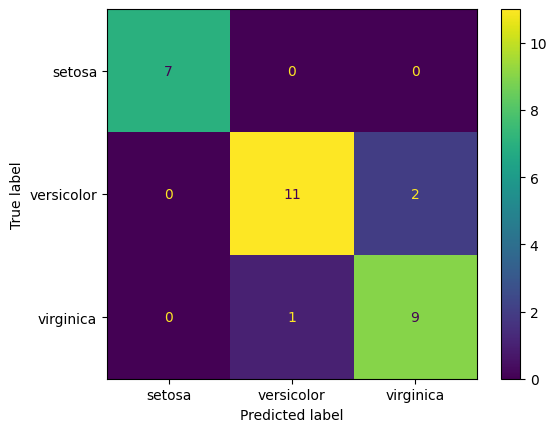

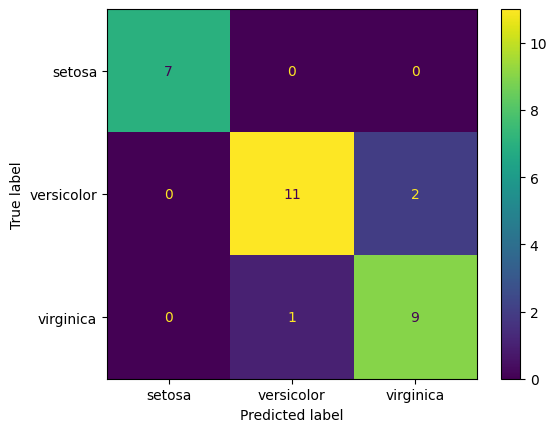

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=iris.target_names                              
)
display.plot();

Matice záměn (**confusion matrix**) nám dává daleko více informace. Na obrázku vidím, 
kolik vzorků z třídy dané řádkem bylo klasifikováno do třídy dané sloupcem.

Tedy v našem případě: Jeden vzor typu Virginica byl oklasifikován chybně jako Versicolor, dva vzory typu Versicolor byly oklasifikovány chybně jako Virginica. 

## Metriky pro binární klasifikaci

Nyní se podíváme na binární klasifikaci (klasifikaci do dvou tříd). Vezměme si data *breast_cancer*, která obsahují
pozitivní a negativní rakovinové nálezy. 
Abychom měli srovnání různých řešení, vezmeme si dva klasifikátory, jednak SVC (*Support Vector Machine* klasifikátor, česky metoda podpůrných vektorů, ale český název se nepoužívá. Více informací viz [wiki](https://cs.wikipedia.org/wiki/Support_vector_machines)) a pak tzv. *Dummy* klasifikátor, který slouží pouze jako baseline a implementuje triviální řešení. 

In [7]:
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# natáhneme data a rozdělíme na trénovací a testovací
X, y = datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

# vytvoříme a natrénujeme klasifikátory 
klasifikator = SVC(probability=True) # probability=True zajišťuje pozdější možnost použití metody predic_proba
klasifikator.fit(X_train, y_train)

dummy = DummyClassifier()
dummy.fit(X_train, y_train)

# oklasifikujeme si testovací vzorky 
y_pred = klasifikator.predict(X_test)
y_dummy = dummy.predict(X_test)

# spočteme accuracy
print("SVC accuracy ", accuracy_score(y_test, y_pred))
print("dummy accuracy ", accuracy_score(y_test, y_dummy))

SVC accuracy  0.916083916083916
dummy accuracy  0.6293706293706294


In [8]:
klasifikator.predict(X_test)


array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0])

In [9]:
dummy.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Nemělo by nás překvapit, že dummy klasifikátor predikuje vše jako většinovou třídu. Je to hloupý klasifikátor, který jde cestou nejmenšího odporu. 

Pro více informace, můžeme použít metodu `predict proba`, která vrátí pro každou třídu stupeň náležení do dané třídy. Zobrazme si např. hned první vzorek:

In [10]:
klasifikator.predict_proba(X_test[0:1])

array([[0.27316851, 0.72683149]])

Vzorek zařadíme do první třídy (pozitivní nález), můžeme též říci, že do této třídy patří s pravděpodobností cca 0.7. 

I při binární klasifikaci se může hodit matice záměn. Zobrazme si ji.

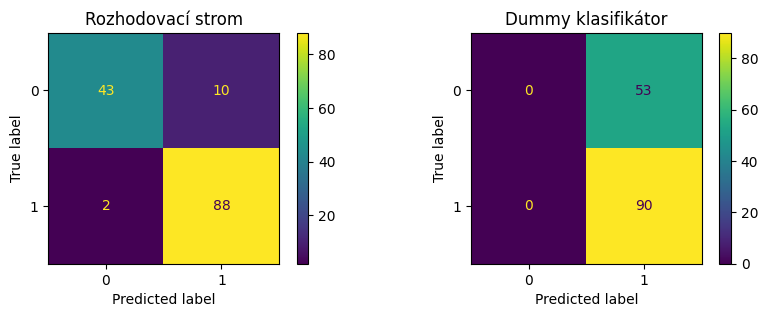

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

ConfusionMatrixDisplay.from_predictions(
    y_test, klasifikator.predict(X_test), ax=ax[0]
)
ax[0].set_title("Rozhodovací strom")

ConfusionMatrixDisplay.from_predictions(
    y_test, dummy.predict(X_test), ax=ax[1]
)
ax[1].set_title("Dummy klasifikátor");

Třídu 0 označujeme jako negativní, třídu 1 jako positivní. Dva pozitivní vzorky byly označeny za negativní, 
takovýmto případům říkáme falešně negativní (**false negative**). Deset negativních vzorků bylo označeno jako positivní, to jsou tzv. falešně positivní (**false positive**) vzory. U dummy klasifikátoru je naopak vše označeno za pozitivní, máme tedy 53 falešně negativních vzorků.

Počty falešně positivních a falešně negativních případů jsou pro hodnocení úspěšnosti binární klasifikace zásadní. 
Správně klasifikované vzorky označujeme jako **true positive** a **true negative**. 

Obrázek níže ilustruje rozdělní vzorků na **true positive**, **true negative**, **false negative** a **false positive**. Oranžová barva reprezentuje pozitivní vzorky, modrá negativní. Vzorky uvnitř kola označil klasifikátor jak pozitivní (zelená oblast je správně klasifikovaná,  tedy **true positive**, a červená špatně klasifikovaná, **false positive**).  Vzorky vně kola, označil klasifikátor jako negativní. Oranžové vně kola jsou tedy **false negative**, modré vně kola jsou **true negative**.  

![obrazek_true_false_positive_negative](static/np_2025.png)

## Precision, recall, F1 skóre

Klasifikační metrika známá jako **precision** říká, kolik vzorků označených za pozitivních je opravdu pozitivních. 

![precision](static/precision.png)

TP označuje počet správně označených pozitivních vzorků (**true positives**) <br>
FP označuje počet falešně pozitivních vzorků (**false negatives**) 

Jedná se o neplaný poplach = precision

Metrika **recall** říká, kolik pozitivních vzorků bylo podchyceno klasifikátorem (klasifikováno jako pozitivní).

![recall](static/recall.png)

P je počet všech pozitivních vzorků, ten se rozpadá na TP (**true positives**) a FN (**false negatives**).

Nesnaž se vzorečky zapamatovat, zamysli se nad tím, co nám říkají. S tím ti pomůže obrázek výše a následující příklad z [Wikipedie](https://en.wikipedia.org/wiki/Precision_and_recall). 

Představ si, že máš počítačový program na rozpoznávání psů na fotografiích. Máš fotku 12 psů a několika koček.
Program ti na fotografii najde 8 psů. Pět z těchto 8 psů jsou opravdu psi (**true positive**), ale zbylí dva jsou ve skutečnosti kočky (**false positive**). **Precision** programu je 5/8 (0.625), zatímco **recall** je 5/12 (cca 0.417). **Precision** se dá interpretovat jako míra užitečnosti výsledku, **recall** říká, jak moc je výsledek kompletní (kolik psů z těch co jsme chtěli najít, jsme opravdu našli).  

Knihovna Scikit-learn má pro tebe samozřejmě připravené funkce na výpočet těchto *precision* a *recall*, zobrazme si je tedy pro náš rozhodovací strom a pro dummy klasifikátor.

In [12]:
from sklearn.metrics import precision_score, recall_score

print("DecisionTree")
print("Precision: ", precision_score(y_test, y_pred))
print("Recall:    ", recall_score(y_test, y_pred))

DecisionTree
Precision:  0.8979591836734694
Recall:     0.9777777777777777


In [13]:
print("Dummy")
print("Precision: ", precision_score(y_test, y_dummy))
print("Recall:    ", recall_score(y_test, y_dummy))

Dummy
Precision:  0.6293706293706294
Recall:     1.0


Zda je pro nás důležitější precision nebo recall, záleží na konkrétní úloze. 
Někdy vadí více falešně pozitivní případy (příliš mnoho relevantních mailů označených za spam), 
jindy bude více vadit nezachycený pozitivní případ (neodhalený výskyt nemoci). 

Další často používanou metrikou je tzv. **F1 skóre**. Kombinuje *precision* a *recall*, a to tak, že obě tyto metriky mají stejnou váhu (Přispívají stejnou měrou k výsledku). Čím větší hodnota, tím lepší výsledek. Maximální hodnota je jedna, minimální 0.

![F1](static/f1.png)

In [15]:
from sklearn.metrics import f1_score

print("F1 skóre SVC:    ", f1_score(y_test, y_pred))
print("F1 skóre Dummy:    ", f1_score(y_test, y_dummy))

F1 skóre SVC:     0.9361702127659575
F1 skóre Dummy:     0.7725321888412017


## ROC křivka

Další užitečná charakteristika je tzv. ROC křivka ([wiki](https://cs.wikipedia.org/wiki/ROC_k%C5%99ivka)). Název pochází z anglického Receiver Operating Characteristic, operační charakteristika přijímače.  Křivka vyjadřuje kvalitu binárního klasifikátoru v závislosti 
na klasifikačním prahu. 

Co je to klasifikační práh? Představ si, že v úloze na `breast cancer` nebude naučený model vracet hodnoty 0/1 (negativní, pozitivní nález), ale číslo typu `float` udávající pravděpodobnost (nebo nějakou míru) náležení do pozitivní třídy.

V nejjednodušším případě budeš vzorky s pravděpodobností větší než 0.5 klasifikovat jako pozitivní,  ostatní jako negativní. Můžeš ale chtít být opatrná a dovyšetřit i pacienty, kteří mají horší nález, i když ne tak špatný, aby model dával odezvu větší než 0.5. Pak tento práh nebude 0.5, ale např. 0.4. Můžeš být zastánce přístupu "nejhorší je smrt z vystrašení" a rozhodneš se dovyšetřit jen pacienty s opravdu špatným nálezem. Pak nastavíš práh např. na 0.7. Jaký přístup je potřeba záleží na konkrétní situaci. 

ROC křivka zobrazuje vztah mezi pravděpodobností detekce (**true positive rate**, senzitivita, recall) TPR a pravděpodobností falešného poplachu (**false positive rate**) FPR. 

![roc](static/roc.png)

P, N ... jsou počty všech pozitivních/negativních vzorků 

ROC křivka zobrazuje na ose x pravděpodobnost falešného poplachu, na ose y pravděpodobnost detekce. Toto pro všechny klasifikační prahy. Čím vyšší klasifikační práh, tím nižší pravděpodobnost falešného poplachu i nižší senzitivita. Čím menší klasifikační práh, tím větší pravděpodobnost detekce (senzitivita) i větší nebezpečí falešného poplachu. 

Čím je křivka blíže hornímu levému rohu, tím pro klasifikátor lépe. Naprosto ideální situace by byla, TPR = 1.0, tedy všechny pozitivní vzorky jsou klasifikovány jako pozivní, a FPR = 0.0, žádný z negativních není klasifikován jako pozitivní.

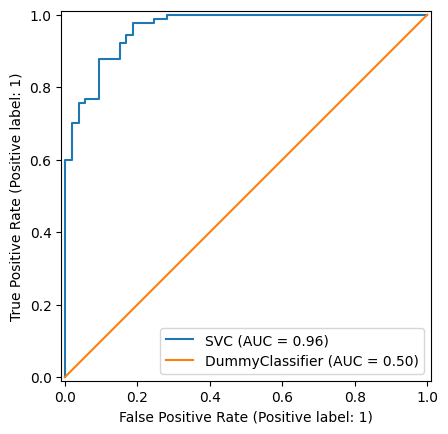

In [16]:
from sklearn.metrics import RocCurveDisplay

ax = plt.subplot() 
klasifikator_disp = RocCurveDisplay.from_estimator(klasifikator, X_test, y_test, ax=ax)
dummy_disp = RocCurveDisplay.from_estimator(dummy, X_test, y_test, ax=ax)


Hodnota AUC (Area Under the Curve) udává obsah plochy pod ROC křivkou. Čím větší plocha, tím lepší klasifikátor.  